In [2]:
from dataclasses import dataclass, field
from typing import Optional, Any, Dict, List

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

Загрузим датасет, уберем айди студента и изменим поле оценки

In [3]:
data = pd.read_csv("student_petf.csv")
data = data.iloc[:, 1:]
data["GRADE"] = data["GRADE"].apply(lambda x: 0 if x <= 3 else 1)
data

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,...,C23,C24,C25,C26,C27,C28,C29,C30,COURSE ID,GRADE
0,2,2,3,3,1,2,2,1,1,1,...,1,1,3,2,1,2,1,1,1,0
1,2,2,3,3,1,2,2,1,1,1,...,1,1,3,2,3,2,2,3,1,0
2,2,2,2,3,2,2,2,2,4,2,...,1,1,2,2,1,1,2,2,1,0
3,1,1,1,3,1,2,1,2,1,2,...,1,2,3,2,2,1,3,2,1,0
4,2,2,1,3,2,2,1,3,1,4,...,2,1,2,2,2,1,2,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,2,1,2,3,1,1,2,1,1,2,...,1,1,2,1,2,1,3,3,9,1
141,1,1,2,4,2,2,2,1,4,2,...,1,1,3,2,2,1,5,3,9,1
142,1,1,1,4,2,2,2,1,1,1,...,1,1,3,3,2,1,4,3,9,0
143,2,1,2,4,1,1,1,5,2,3,...,2,1,2,1,2,1,5,3,9,1


In [4]:
@dataclass
class Node:
    feature: Optional[str] = None
    value: Optional[Any] = None
    is_leaf: bool = False
    prediction: Optional[Any] = None
    children: Dict[Any, 'Node'] = field(default_factory=lambda: {})
    
    def add_child(self, value: Any, child_node: 'Node') -> None:
        self.children[value] = child_node


In [5]:
class C45:
    def __init__(self, data: pd.DataFrame, target_col: str):
        self.data = data
        self.target_col = target_col
        self.features = list(data.columns.drop(target_col))
    
    def _entropy(self, target_col: pd.Series) -> float:
        elements, counts = np.unique(target_col, return_counts=True)
        entropy = 0.0
        for count in counts:
            prob = count / np.sum(counts)
            entropy -= prob * np.log2(prob)
        return entropy

    def _info(self, split_attr: str) -> float:
        total_entropy = self._entropy(self.data[self.target_col])
        vals, counts = np.unique(self.data[split_attr], return_counts=True)
        
        weighted_entropy = 0.0
        for i, val in enumerate(vals):
            subset = self.data[self.data[split_attr] == val]
            prob = counts[i] / np.sum(counts)
            weighted_entropy += prob * self._entropy(subset[self.target_col])
        return total_entropy - weighted_entropy
    
    
    def _build_tree(self,
                   data: pd.DataFrame,
                   parent_node: Optional[Any],
                   features: List[str]) -> Node:
        if len(np.unique(data[self.target_col])) == 1:
            return Node(is_leaf=True, prediction=np.unique(data[self.target_col])[0])

        if len(data) == 0:
            common_class = np.unique(self.data[self.target_col])[
                np.argmax(np.unique(self.data[self.target_col], return_counts=True)[1])
            ]
            return Node(is_leaf=True, prediction=common_class)
        
        parent_node_сlass = np.unique(self.data[self.target_col])[
            np.argmax(np.unique(self.data[self.target_col], return_counts=True)[1])
        ]
        if len(features) == 0:
            return Node(is_leaf=True, prediction=parent_node_сlass)
        item_values = [
            self._info(feature) for feature in features
        ]
        best_feature_index = int(np.argmax(item_values))
        best_feature = features[best_feature_index]
        root = Node(feature=best_feature)
        
        remaining_features = [feature for feature in features if feature != best_feature]
        
        for value in np.unique(data[best_feature]):
            subset = data[data[best_feature] == value]
            child_node = self._build_tree(subset, parent_node_сlass, remaining_features)
            root.add_child(value, child_node)
        
        return root
    
    def fit(self):
        return self._build_tree(self.data, None, self.features)
    
    def predict_one(self, node: Node, row: pd.Series) -> Any:
        if node.is_leaf:
            return node.prediction
        value = row[node.feature]
        if value in node.children:
            return self.predict_one(node.children[value], row)
        else:
            return 0.5

    def predict(self, node: Node, data: pd.DataFrame) -> List[Any]:
        return [self.predict_one(node, row) for _, row in data.iterrows()]

    def print_tree(self, node: Node, indent: str = "") -> None:
        if node.is_leaf:
            print(f"{indent}Predict: {node.prediction}")
        else:
            for value, child in node.children.items():
                print(f"{indent}[{node.feature} = {value}]")
                self.print_tree(child, indent + "\t")
        


In [6]:
data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)

tree = C45(data_train, "GRADE")
root = tree.fit()
tree.print_tree(root)

[COURSE ID = 1]
	[C29 = 1]
		Predict: 0
	[C29 = 2]
		Predict: 0
	[C29 = 3]
		[C4 = 2]
			Predict: 0
		[C4 = 3]
			[C8 = 1]
				[C1 = 1]
					Predict: 1
				[C1 = 2]
					Predict: 0
			[C8 = 2]
				[C1 = 1]
					Predict: 0
				[C1 = 2]
					[C12 = 1]
						[C2 = 1]
							Predict: 1
						[C2 = 2]
							Predict: 0
		[C4 = 4]
			[C8 = 2]
				[C1 = 1]
					Predict: 0
				[C1 = 2]
					Predict: 1
		[C4 = 5]
			Predict: 0
	[C29 = 4]
		[C4 = 3]
			[C8 = 1]
				[C1 = 2]
					[C12 = 2]
						Predict: 1
					[C12 = 3]
						Predict: 0
					[C12 = 4]
						Predict: 1
			[C8 = 2]
				[C1 = 1]
					[C12 = 3]
						[C2 = 2]
							[C21 = 1]
								Predict: 0
							[C21 = 3]
								Predict: 1
				[C1 = 2]
					Predict: 0
				[C1 = 3]
					Predict: 0
		[C4 = 4]
			[C8 = 1]
				Predict: 1
			[C8 = 3]
				Predict: 0
		[C4 = 5]
			Predict: 0
	[C29 = 5]
		[C4 = 3]
			[C8 = 1]
				[C1 = 2]
					[C12 = 2]
						Predict: 1
					[C12 = 3]
						[C2 = 2]
							[C21 = 1]
								[C16 = 4]
									[C25 = 

In [7]:
y_pred = tree.predict(root, data_test)

In [8]:
def rates(y_true, y_predicted):
    tp, fp, tn, fn = 0, 0, 0, 0
    for true_label, pred_label in zip(y_true, y_predicted):
        if true_label == pred_label:
            if true_label == 1: tp += 1
            else: tn += 1
        else:
            if true_label == 1: fp += 1
            else: fn += 1
    return tp, fp, tn, fn

def evaluate(y_true: List[Any], y_predicted: List[Any]) -> tuple[float, float, float]:
    tp, fp, tn, fn = rates(y_true, y_predicted)
    accuracy = (tp + fp) / len(y_true) 
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return accuracy, precision, recall

In [9]:
accuracy, precision, recall = evaluate(data_test["GRADE"], y_pred)
print(f"{accuracy=:.3}")
print(f"{precision=:.3}")
print(f"{recall=:.3}")

accuracy=0.414
precision=0.5
recall=0.462


In [18]:
def roc_curve(y_true, y_proba):
    tpr_list, fpr_list = [], [] 
    for i, y in enumerate(y_true):
        if i == 0:
            continue
        tp, fp, tn, fn = rates(y_true[:i], y_proba[:i])
        if (tp + fn) == 0:
            tpr = 0
        else:
            tpr = tp / (tp + fn)
        if (fp + tn) == 0:
            fpr = 0
        else:
            fpr = fp / (fp + tn)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

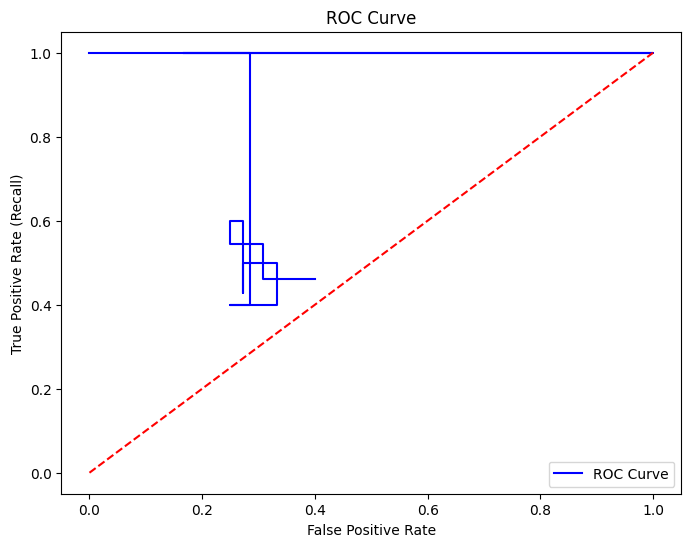

In [19]:
tpr_list, fpr_list = roc_curve(data_test["GRADE"], y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr_list, tpr_list, color='blue', label='ROC Curve')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [ ]:
from sklearn import metrics

fpr, tpr, _ = metrics.roc_curve(data_test["GRADE"], y_pred)

# построение ROC кривой
plt.plot(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
auc = metrics.roc_auc_score(data_test["GRADE"], y_pred)
print("AUC: %.3f" % auc)